# Let's do some biomechanics !!

Now, we are working with a arm model, actuated by muscles and pure joint torques (to compensate for model weakness). 
The goal is, starting from an initial position, to perform a reaching  task with this arm, by superimposing two markers. 
The first one (called 'target' in the model), is fixed in the scene.
The second one (called 'COM_hand' in the model) is fixed on the arm, in the *ulna* coordinate system.

The ocp to solve is as follow:
- Movement of $3s$ divided into $50$ shooting points
- The state variables are the generalized position (q) and velocities (qdot)
- The control variables are the muscle activations (a) 
- Cost functions: minimize the control effort at all time and minimize the squared Euclidean distance between the two markers at the final node
- Initial guess is arbitrarily set to $0.5$ for muscle activations and to $0$ for all other variables

In [1]:
# So first, let's import all the required classes
import biorbd_casadi as biorbd
from bioptim import *

In [6]:
# Let's define the OCP
final_time = 0.5
n_shooting = 20

# Load the model and define some aliases
model = biorbd.Model("models/arm26.bioMod")
nq = model.nbQ()
ndq = model.nbQdot()
ntau = model.nbGeneralizedTorque()
nmus = model.nbMuscleTotal()

# Add objective functions
objective_functions = ObjectiveList()
objective_functions.add(ObjectiveFcn.Lagrange.MINIMIZE_STATE, key="q", weight = 5)
objective_functions.add(ObjectiveFcn.Lagrange.MINIMIZE_CONTROL, key="tau", weight = 20)
objective_functions.add(ObjectiveFcn.Lagrange.MINIMIZE_CONTROL, key="muscles")
objective_functions.add(
    ObjectiveFcn.Mayer.SUPERIMPOSE_MARKERS, first_marker="target", second_marker="COM_hand", weight=1e3
)

# Dynamics
dynamics = DynamicsList()
dynamics.add(DynamicsFcn.MUSCLE_DRIVEN, with_torque=True)

# Path constraint
x_bounds = BoundsList()
x_bounds.add(bounds=QAndQDotBounds(model))
x_bounds[0][:, 0] = (0.07, 1.4, 0, 0)

# Initial guess
x_init = InitialGuessList()
x_init.add([1.57] * nq + [0] * ndq)

# Define control path constraint
muscle_min, muscle_max, muscle_init = 0, 1, 0.5
tau_min, tau_max, tau_init = -10, 10, 0
u_bounds = BoundsList()
u_bounds.add(
    [tau_min] * ntau + [muscle_min] * nmus,
    [tau_max] * ntau + [muscle_max] * nmus,
)

u_init = InitialGuessList()
u_init.add([tau_init] * ntau + [muscle_init] * nmus)
# ------------- #

ocp = OptimalControlProgram(
    model,
    dynamics,
    n_shooting,
    final_time,
    x_init,
    u_init,
    x_bounds,
    u_bounds,
    objective_functions,
    n_threads=10
)

# Have a look on the ocp
ocp.print(to_console=False,to_graph=False)

In [7]:
sol = ocp.solve()

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     1024
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1521

Total number of variables............................:      240
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      240
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9645693e+01 2.21e+00 9.30e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.2004261e+02 8.42e-02 2.32e+00  -1.0 3.54e-01  -0.5 1.00e+00 5.00e-01h  2
  91  2.1913264e+02 1.17e-01 3.99e+00  -1.0 2.20e-01  -0.1 1.00e+00 1.00e+00f  1
  92  2.1947166e+02 1.45e-01 1.83e+00  -1.0 7.25e-01  -0.5 1.00e+00 1.00e+00h  1
  93  2.1880662e+02 2.10e-01 2.43e+00  -1.0 2.31e+00  -1.0 1.00e+00 2.95e-01F  1
  94  2.1826267e+02 4.52e-01 4.80e+00  -1.0 4.94e+00    -  2.46e-01 2.16e-01F  1
  95  2.1771752e+02 4.32e-01 1.45e+01  -1.0 3.50e-01    -  5.89e-01 3.23e-02F  1
  96  2.1826446e+02 3.77e-01 4.36e+00  -1.0 4.50e-01    -  7.83e-01 1.25e-01h  4
  97  2.1434677e+02 2.84e-01 2.36e+00  -1.0 2.30e-01   0.3 1.00e+00 1.00e+00H  1
  98  2.1684885e+02 2.43e-01 1.70e+00  -1.0 9.83e-01    -  5.33e-01 4.74e-01h  1
  99  2.1881060e+02 2.26e-01 2.44e+00  -1.0 2.55e-01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1895181e+02 2.41e-01

 187  2.1546635e+02 1.34e-01 6.89e-01  -3.8 1.36e-01  -0.2 1.00e+00 2.84e-01h  2
 188  2.1557805e+02 1.25e-01 1.22e+00  -3.8 1.75e-01  -0.7 1.00e+00 6.77e-02h  3
 189  2.1558381e+02 1.24e-01 2.03e+00  -3.8 5.85e-01    -  8.96e-01 3.82e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  2.1558454e+02 1.24e-01 2.11e+00  -3.8 5.86e-01    -  1.00e+00 4.88e-04h 12
 191  2.1573419e+02 6.41e-02 8.73e-01  -3.8 5.71e-01    -  7.11e-01 3.56e-01H  1
 192  2.1704129e+02 1.37e-01 1.20e+01  -3.8 3.70e-01    -  1.00e+00 1.00e+00H  1
 193  2.1675336e+02 1.36e-01 1.14e+01  -3.8 2.73e+00  -0.2 1.12e-02 7.55e-03f  3
 194  2.1545807e+02 1.30e-01 5.08e+00  -3.8 8.52e+01  -0.7 8.00e-04 1.34e-03f  1
 195  2.1108294e+02 6.18e-01 1.18e+01  -3.8 6.08e+00  -0.3 7.51e-01 1.48e-01f  1
 196  2.1127597e+02 5.89e-01 1.94e+00  -3.8 1.12e+00   0.1 8.42e-01 4.74e-02h  1
 197  2.1407015e+02 2.93e-01 2.44e+00  -3.8 4.04e-01  -0.3 2.36e-01 5.00e-01h  2
 198  2.1575506e+02 5.52e-02

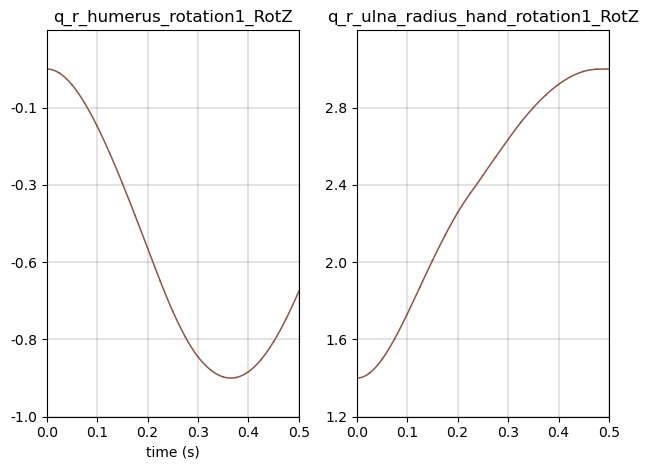

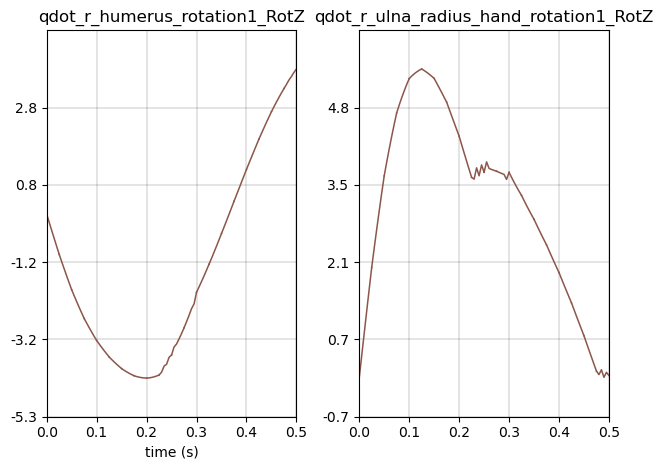

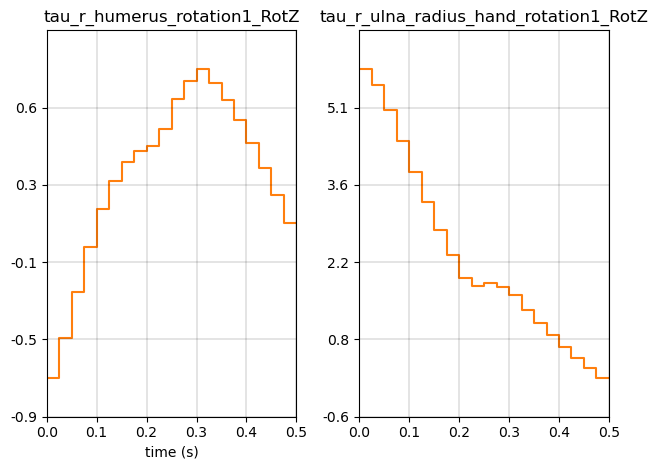

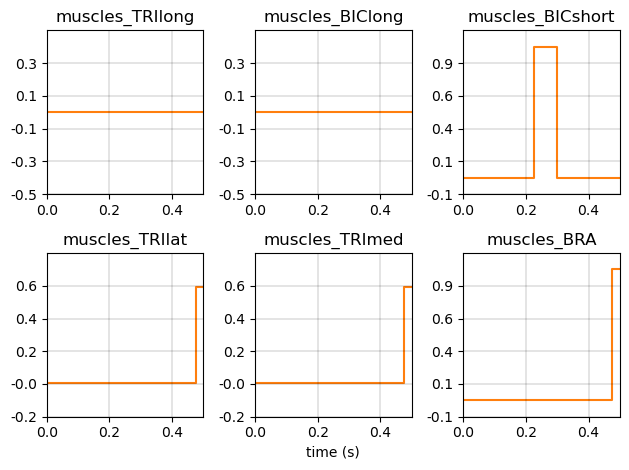

In [8]:
sol.graphs(automatically_organize=False)

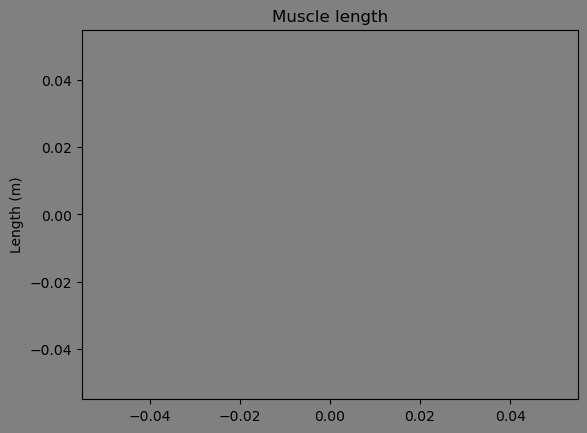

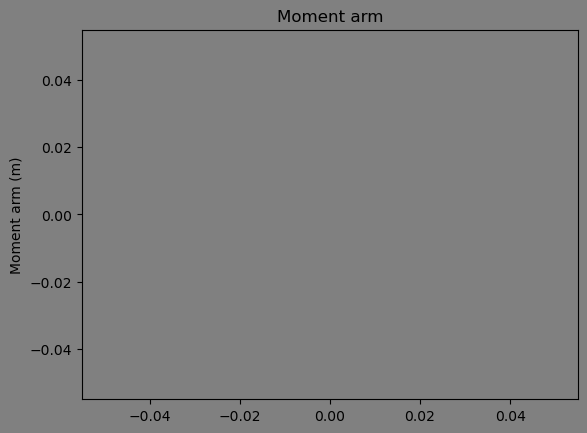

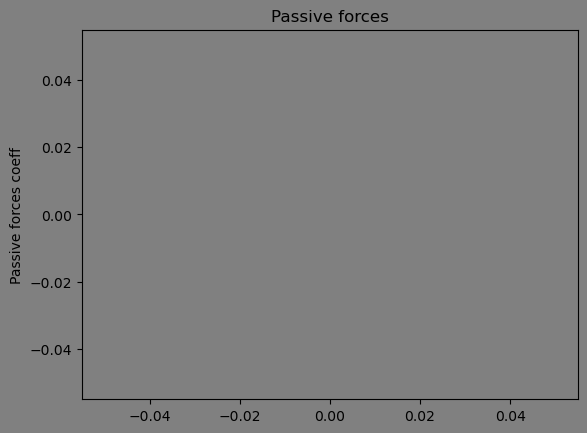

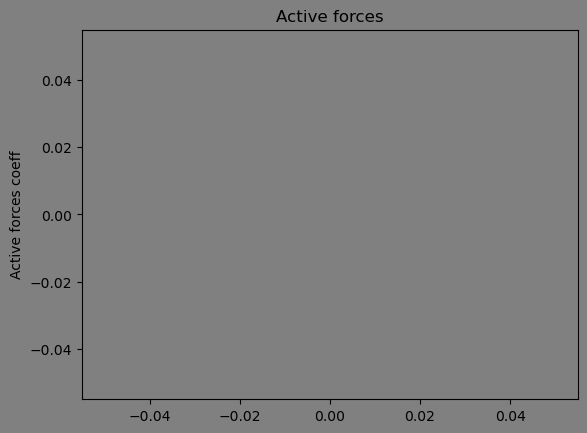

In [9]:
sol.animate(n_frames=50)
# This would work locally on your computer. Unfortunately, it is nor currently working with remote notebooks...
# Call one of the workshop organizers, so you can see the motion animation.

In [ ]:
out = sol.print_cost()

Let us compute the distance between the two markers at the end of the motion, based on the information printed in the console above. Keep in mind that SUPERIMPOSE_MARKERS is a quadratic cost.


In [10]:
import numpy as np
# Prepare the casadi function to call
markers = biorbd.to_casadi_func("mark1", model.markers, ocp.nlp[0].states["q"].mx)

# Extract results
q = sol.states["q"][:, -1]
target_idx = biorbd.marker_index(model, "target")
hand_idx = biorbd.marker_index(model, "COM_hand")

# Compute the Euler distance
dist = np.sqrt(np.sum((markers(q)[:, target_idx] - markers(q)[:, hand_idx])**2))
print(f"At the final node, the distance between the 2 markers is {round(dist, 3) * 1000}mm")


At the final node, the distance between the 2 markers is 338.0mm


You find it too large ? Try to solve the problem again by increasing the weight of the objective on the markers matching !

In [ ]:
...